<h1>Exploring & Visualising Australian Historical Temperature Data in Python</h1>

After enduring the hottest Australian summer on record in 2019/20 sheltered inside with air-con and air purifier running as large parts of my home state of New South Wales burned, I decided to run some exploratory analysis on the Bureau of Meteorology's fantastic [ACORN-SAT 2.1 database](http://www.bom.gov.au/climate/data/acorn-sat/). 
>The Australian Climate Observations Reference Network – Surface Air Temperature (ACORN-SAT) is the dataset used by the Bureau of Meteorology to monitor long-term temperature trends in Australia. ACORN-SAT uses observations from 112 weather stations in all corners of Australia, selected for the quality and length of their available temperature data.



<h2>Setup</h2>

Let's get started by importing the required packages

In [477]:
import pandas as pd
import chart_studio.plotly as py
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import string
import glob
import plotly.express as px

Some Plotly visualisations require a Mapbox account - you can register for the basic account tier for free.

In [478]:
#You will need your own token
token = open(".mapbox_token").read() 

We then create a dataframe from a CSV containing a list of weather station names and locations

In [479]:
places = pd.read_csv("acorn_sat_v2.1.0_stations.csv")
places.head()

,stn_num,stn_name,lat,lon,elevation
0,1019,Kalumburu,-14.30,126.65,23
1,2079,Halls Creek,-18.23,127.67,409
2,3003,Broome,-17.95,122.24,7
3,4032,Port Hedland,-20.37,118.63,6
4,4106,Marble Bar,-21.18,119.75,182


The dataset of temperature readings comes split into 'max' and 'min' folders containing a CSV for each weather station. The below code loops through each CSV, creating a dataframe for each station and running some pre-processing, before concatenating them together.

In [481]:
#Loop through the weather station CSVs, run some preprocessing and add the dataframes to a temporary list
path = "max"
li = []
 
for count, f in enumerate(glob.glob(path + "/*.csv")):
    df = pd.read_csv(f, index_col=None, header=0)
    df['site number'] = df['site number'][0]
    df['site name'] = string.capwords(df['site name'][0])
    df['lat'] = places['lat'][count]
    df['lon'] = places['lon'][count]
    df = df.drop(df.index[0])
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['long term average'] = df['maximum temperature (degC)'][(df['year']<1980) & (df['year']>1949)].mean()
    li.append(df)

#Concatenate list of dataframes into one large dataframe of nearly 4 million rows. 
df = pd.concat(li, axis=0, ignore_index=True)

In [482]:
#Do likewise with the weather station data from the 'min' dataset
path = "min"
li = []

for count, f in enumerate(glob.glob(path + "/*.csv")):
    df_min = pd.read_csv(f, index_col=None, header=0)
    df_min = df_min.drop(df_min.index[0])
    li.append(df_min)

df_min = pd.concat(li, axis=0, ignore_index=True)

In [483]:
#Add the minimum temperature data to the first dataframe
df['min'] = df_min['minimum temperature (degC)']
df.rename(columns = {"maximum temperature (degC)": "max"}, inplace=True)

df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.to_datetime(df['date']).dt.year


<h2>Exploring the Australian Bureau of Meteorology data</h2>

We start by printing some basic statistics describing the dataset

In [871]:
df.head()

,date,max,site number,site name,lat,lon,year,long term average,min
0,1941-09-01,31.0,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,20.5
1,1941-09-02,31.0,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,20.5
2,1941-09-03,30.5,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,19.3
3,1941-09-04,38.8,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,21.0
4,1941-09-05,32.1,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,19.6


In [485]:
df.dtypes

date                 datetime64[ns]
max                         float64
site number                 float64
site name                    object
lat                         float64
lon                         float64
year                          int64
long term average           float64
min                         float64
dtype: object

In [486]:
df.describe(include=[np.object])

,site name
count,3882887
unique,112
top,Wagga Wagga Amo
freq,40177


There are a not insignificant number of missing values in this dataset, however given we are exploring mean temperature values this is not especially critical.

In [487]:
pd.isnull(df['max']).value_counts()

False    3779214
True      103673
Name: max, dtype: int64

<h2>Visualising Extreme Heat Events</h2>

These are the days when you just can't afford for your air-con to break. When koalas come down from their gum trees for a swim in the billabong. Using the BoM dataset let's find out where in Australia you would be better off living underground, and whether the occurences of 40°C+ (104 °F) are on the rise. 

In [888]:
dfheat = df.copy()

#Tag days where the temperature reading exceeded 40°C (104 °F)
dfheat['Average Days of 40C+ / Year'] = np.where(dfheat['max'] >= 40, 1, 0)

dfheat.head()

,date,max,site number,site name,lat,lon,year,long term average,min,Average Days of 40C+ / Year
0,1941-09-01,31.0,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,20.5,0
1,1941-09-02,31.0,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,20.5,0
2,1941-09-03,30.5,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,19.3,0
3,1941-09-04,38.8,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,21.0,0
4,1941-09-05,32.1,1019.0,Kalumburu,-14.3,126.65,1941,33.678851,19.6,0


<h3>Hottest Places in Australia (2019)</h3>
Let's start by finding the Australian locations with the most days of extreme heat (40°C / 104 °F) in 2019 

In [873]:
#Slice dataframe and select the top 10 locations
df_hottest = dfheat[dfheat['year'] == 2019]
df_hottest = df_hottest.groupby(["site name"]).sum()
df_hottest = df_hottest.sort_values('Average Days of 40C+ / Year', ascending=False)
df_hottest = df_hottest.reset_index().loc[:9, :]

df_hottest

,site name,max,site number,lat,lon,year,long term average,min,Average Days of 40C+ / Year
0,Marble Bar,13335.4,1498690.0,-7730.70,43708.75,736935,12923.318800,7473.3,154
1,Rabbit Flat,13120.6,5718090.0,-7365.70,47453.65,736935,12218.645090,5216.3,139
2,Karijini North,12920.3,1860770.0,-8139.50,43234.25,736935,11679.412979,7623.9,127
3,Tennant Creek Airport,12160.2,5524275.0,-7168.60,48975.70,736935,11404.563166,7292.2,92
4,Victoria River Downs,12802.4,5411125.0,-5986.00,47818.65,736935,12676.517644,7079.4,89
5,Camooweal Township,12520.6,13508650.0,-7270.80,50413.80,736935,11865.371179,6600.0,88
6,Halls Creek Airport,12645.8,758835.0,-6653.95,46599.55,736935,11876.945578,6926.7,77
7,Oodnadatta Airport,11400.5,6220695.0,-10059.40,49439.25,736935,10442.994556,5205.0,74
8,Birdsville Airport,11622.4,13879490.0,-9453.50,50862.75,736935,11004.352290,5546.8,74
9,Learmonth Airport,12208.1,1827555.0,-8117.60,41646.50,736935,11368.705666,6463.8,74


The fact Marble Bar (located in Western Australia) is at the top of this list shouldn't be a surprise. Marble Bar has a hot desert climate with sweltering summers and warm winters. Most of the annual rainfall occurs in the summer. The town set a world record of most consecutive days of 100 °F (37.8 °C) or above, during a period of 160 days from 31 October 1923 to 7 April 1924.

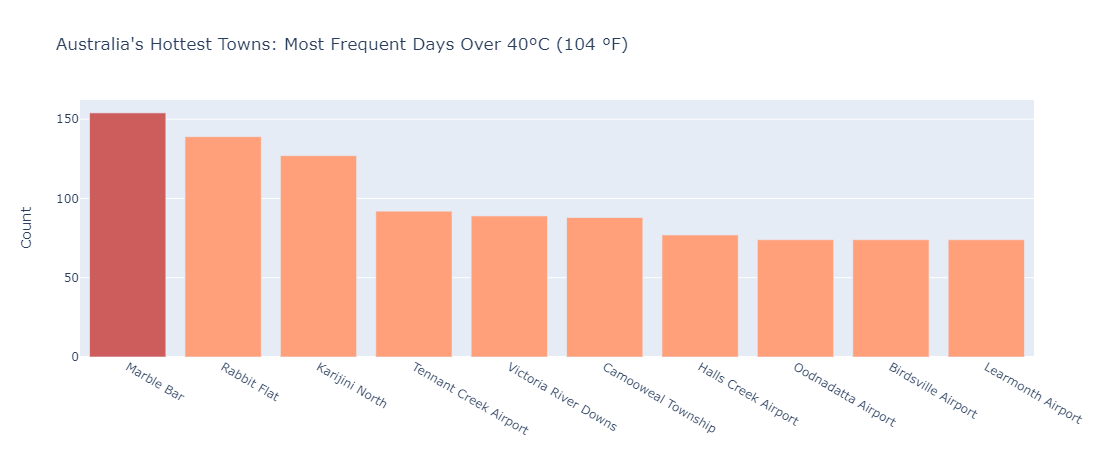

In [949]:
#Create barchart visualisation using Plotly

colors = ['lightsalmon',] * 10
colors[0] = 'indianred'

fig = go.Figure([go.Bar(x=df_hottest['site name'], y=df_hottest["Average Days of 40C+ / Year"], marker_color=colors)])

fig.update_yaxes(title="Count")
fig.update_layout(title_text= "Australia's Hottest Towns: Most Frequent Days Over 40°C (104 °F)", height=450, width=800)


fig.show()

<h3>Occurence of Extreme Weather Events Over Time</h3>
Let's look at whether the number of days over 40°C (104 °F) has increased over time.

In [889]:
#Group dataframe by year and obtain average of days over 40C across weather stations
dfheat = dfheat.groupby([pd.Grouper(key="date", freq="Y")]).mean()*365
dfheat = dfheat.reset_index()
dfheat['year'] = dfheat['date'].dt.year

#Select records from 1950 to present
dfheat = dfheat[dfheat['year'] >= 1950]

dfheat.head()


,date,max,site number,lat,lon,year,long term average,min,Average Days of 40C+ / Year
40,1950-12-31,8835.971305,1.525218e+07,-10921.469084,50952.185347,1950,8957.598089,4584.059041,3.966220
41,1951-12-31,9005.318544,1.511193e+07,-10866.890937,50891.841143,1951,8978.719144,4438.756589,7.076769
42,1952-12-31,8908.120587,1.514267e+07,-10879.187456,50851.405749,1952,8981.081792,4479.180043,8.558434
43,1953-12-31,8953.312144,1.520950e+07,-10895.896354,50861.229167,1953,8971.730128,4441.370431,6.604167
44,1954-12-31,8945.124239,1.520064e+07,-10886.287193,50861.239298,1954,8985.271339,4578.838965,5.784125


Visualising this data, it appears that there is indeed an upward trend showing increasing extreme weather events across Australia

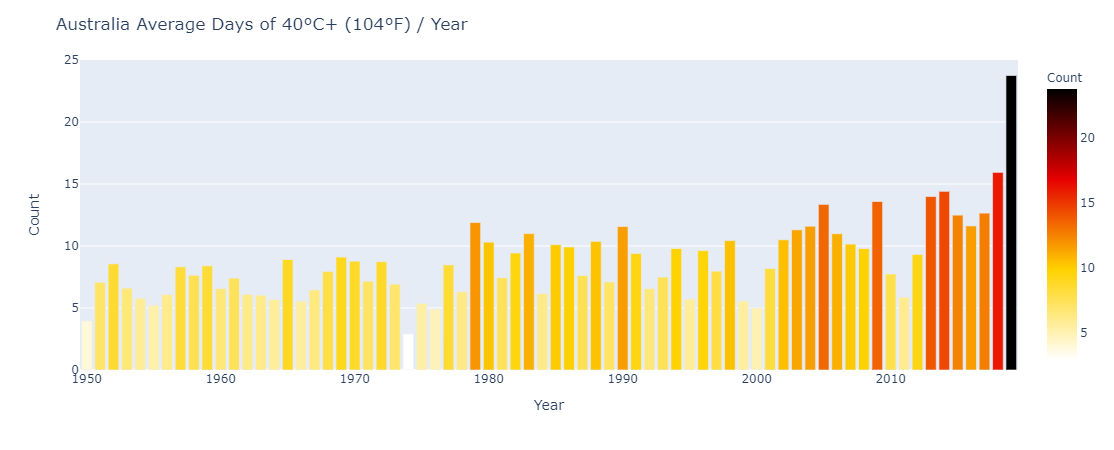

In [950]:
#Visualise the data
fig = px.bar(dfheat, x="year", y="Average Days of 40C+ / Year",
            hover_data=['year', 'Average Days of 40C+ / Year'], 
             color_continuous_scale="hot_r",
             color='Average Days of 40C+ / Year',
             labels={'year':'Year', 'Average Days of 40C+ / Year': "Count"}, height=450)
fig.update_layout(title_text="Australia Average Days of 40°C+ (104°F) / Year")

fig.show()

<h2>Visualising Temperature Data By Season</h2>
Given that there seems to be an increasing trend of extreme weather events, let's explore the averaged temperature data in more detail and whether there is any discernable difference between Summer & Winter records

In [934]:
#Set dataframe date range and group by 3 months
start = '1950-08-01'
end = '2019-12-31'
mask = (df['date'] > start) & (df['date'] <= end)
df_seasons = (
    df.loc[mask]
    .groupby(pd.Grouper(freq="3M", key="date"))
    .mean()
    .iloc[::2]
    .reset_index()
)
#Label grouped months as seasons
df_seasons.loc[1::2, 'season'] = 'Summer'
df_seasons.loc[::2, 'season'] = 'Winter'

#Create temperature range column & year column
df_seasons.loc[:, 'temp_range'] = df_seasons['max'] - df_seasons['min']
df_seasons.loc[:, 'year'] = pd.DatetimeIndex(df_seasons['date']).year

df_seasons.head()

,date,max,site number,lat,lon,year,long term average,min,season,temp_range
0,1950-08-31,19.407288,41655.182796,-29.998925,139.455806,1950,24.522322,11.402815,Winter,8.004473
1,1951-02-28,29.599024,41499.893617,-29.792340,139.485957,1951,24.579390,15.553474,Summer,14.045550
2,1951-08-31,18.503477,41499.893617,-29.792340,139.485957,1951,24.579390,8.935743,Winter,9.567734
3,1952-02-29,30.192992,41116.715789,-29.713474,139.264526,1952,24.657485,15.677567,Summer,14.515425
4,1952-08-31,18.738631,41669.875000,-29.851771,139.345833,1952,24.580083,9.362085,Winter,9.376546


In addition to the data from the Australian Bureau of Meteorology, I've added a dataframe with cold & warm episodes by season from the National Weather Service to identify when El Nino & La Nina events are occurring and the Oceanic Niño Index (ONI) score.

In [935]:
oni_values = pd.read_csv("ONI Values.csv", skiprows=2)
oni_values.head()

,Type,Season,Unnamed: 2,Unnamed: 3,JJA,JAS,ASO,SON,OND,NDJ,DJF,JFM,FMA,MAM,AMJ,MJJ
0,NaN,1950,-,1951,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8,-0.8,-0.5,-0.2,0.2,0.4,0.6
1,ME,1951,-,1952,0.7,0.9,1.0,1.2,1.0,0.8,0.5,0.4,0.3,0.3,0.2,0.0
2,WE,1952,-,1953,-0.1,0.0,0.2,0.1,0.0,0.1,0.4,0.6,0.6,0.7,0.8,0.8
3,WE,1953,-,1954,0.7,0.7,0.8,0.8,0.8,0.8,0.8,0.5,0.0,-0.4,-0.5,-0.5
4,WL,1954,-,1955,-0.6,-0.8,-0.9,-0.8,-0.7,-0.7,-0.7,-0.6,-0.7,-0.8,-0.8,-0.7


In [936]:
#The ONI scores are now added to the corresponding season in the df_seasons dataframe
for count, f in enumerate(oni_values.values):
    df_seasons.loc[count*2, "oni_value"] = float(f[4])
    df_seasons.loc[count*2+1, "oni_value"] = float(f[10])

df_seasons = df_seasons.dropna()

<h3>Visualising Seasonal Average Daily Temperature</h3>
We can now create scatterplots showing average daily temperatures for Summer and for Winter, colour-coded with the ONI data. Red indicates an El Nino event and blue indicates La Nina.

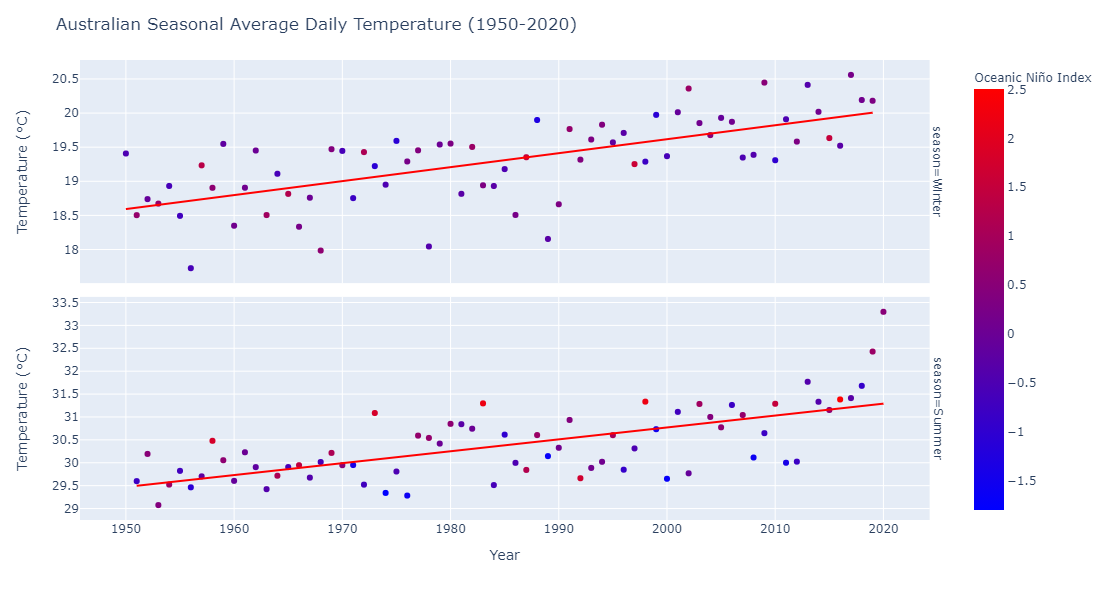

In [937]:
#Create a scatterplot
fig = px.scatter(df_seasons, x="year", y="max", facet_row="season", opacity=1, 
                 labels=dict(year="Year", difference="Average Daily Temperature Range (°C)", oni_value='Oceanic Niño Index'),
                 trendline = "ols", trendline_color_override="red", color="oni_value", color_continuous_scale='bluered')

fig.update_layout(height=600, width=1000, title_text="Australian Seasonal Average Daily Temperature (1950-2020)")

fig.update_xaxes(nticks=10)
fig.update_yaxes(nticks=10, title_text="Temperature (°C)", matches=None)

fig.show()

Temperatures in Summer & Winter have both increased by approximately 1.5°C since 1950, which is also reflected in the number of extreme heat events in the previous section. The data shows that although there is no apparently correlation between ONI and temperature in Winter, Summer El Nino events appear to be correlated with with higher than average temperatures (record heat in 1973, 1983, 1997 & 2019-20 was driven by strong El Nino events), and likewise La Nina events often bring lower than average temperatures (1974-76, 1984, 2000 & 2011-12).

<h3>Visualising Average Daily Temperature Range</h3>
Using the same dataframe, we can assess whether the increase in temperatures is likely to bring about an increased daily temperature range (i.e. colder nights, hotter days) across the BoM weather station locations.

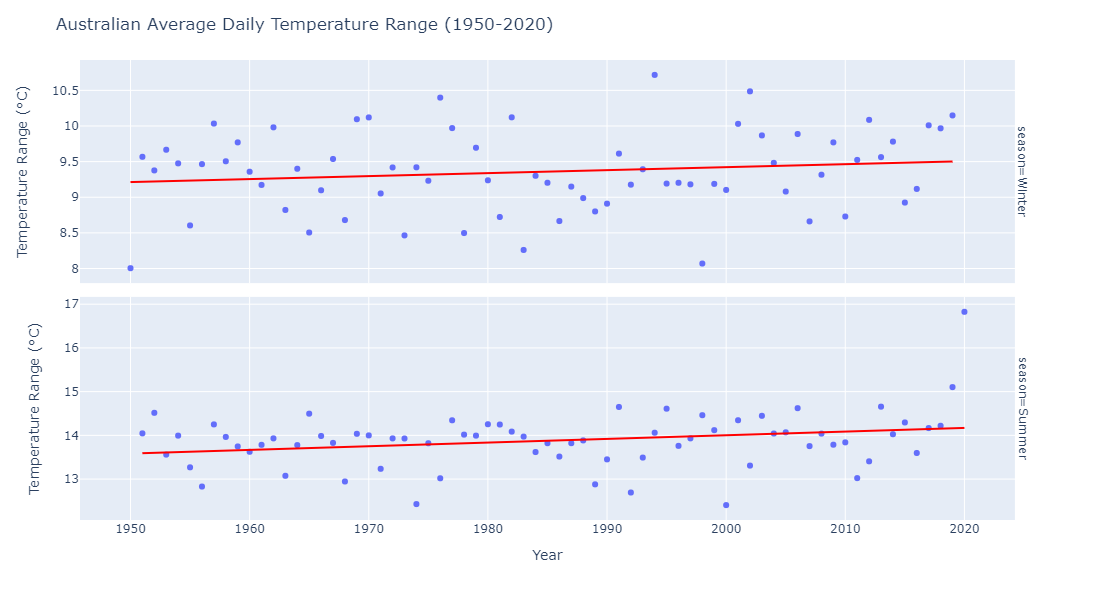

In [895]:
#Create a scatterplot showing average daily temperature range for Summer and one for Winter
fig = px.scatter(df_seasons, x="year", y="temp_range", facet_row="season", opacity=1, 
                 labels=dict(year="Year", temp_range="Temperature Range (°C)"),
                 trendline = "ols", trendline_color_override="red")

fig.update_layout(height=600, width=1000, title_text="Australian Average Daily Temperature Range (1950-2020)")

fig.update_xaxes(nticks=10)
fig.update_yaxes(nticks=10, matches=None)

fig.show()

The trendlines show a very slight increase in the average daily temperature range between 1950-2020, leading to approximately 0.5°C greater difference between min / max temperatures in both Summer & Winter.

<h2>Geospatial Historical Temperature Analysis</h2>

Given we have the coordinates of weather stations Australia-wide, let's create an animated map showing temperature changes over time.

In [938]:
#Consolidate dataframe into yearly average temperatures and group by location.
dfyear = df.copy()[df['year'] >= 1950].groupby(['site name', pd.Grouper(key="date", freq="Y")]).mean()

#Using the long term average for each location between 1950-1980, we can calculate the difference in temperature for each year & location.
dfyear = (
    dfyear.dropna(subset=['max']).
    reset_index()
)
dfyear.loc[:,'+/- Long Term Average'] = (dfyear['max']-dfyear['long term average'])
dfyear = dfyear.round(1)

dfyear.head()

,site name,date,max,site number,lat,lon,year,long term average,min,+/- Long Term Average
0,Albany Airport,1950-12-31,20.1,9999.0,-34.9,117.8,1950,19.8,10.2,0.4
1,Albany Airport,1951-12-31,19.3,9999.0,-34.9,117.8,1951,19.8,10.1,-0.5
2,Albany Airport,1952-12-31,19.4,9999.0,-34.9,117.8,1952,19.8,9.4,-0.4
3,Albany Airport,1953-12-31,19.5,9999.0,-34.9,117.8,1953,19.8,10.0,-0.3
4,Albany Airport,1954-12-31,19.9,9999.0,-34.9,117.8,1954,19.8,10.0,0.1


It's easy to create animations with Plotly's Mapbox integration. For some of the Mapbox style types (like "satellite" used here), you'll need a mapbox access token which can be obtained by registering for free. 

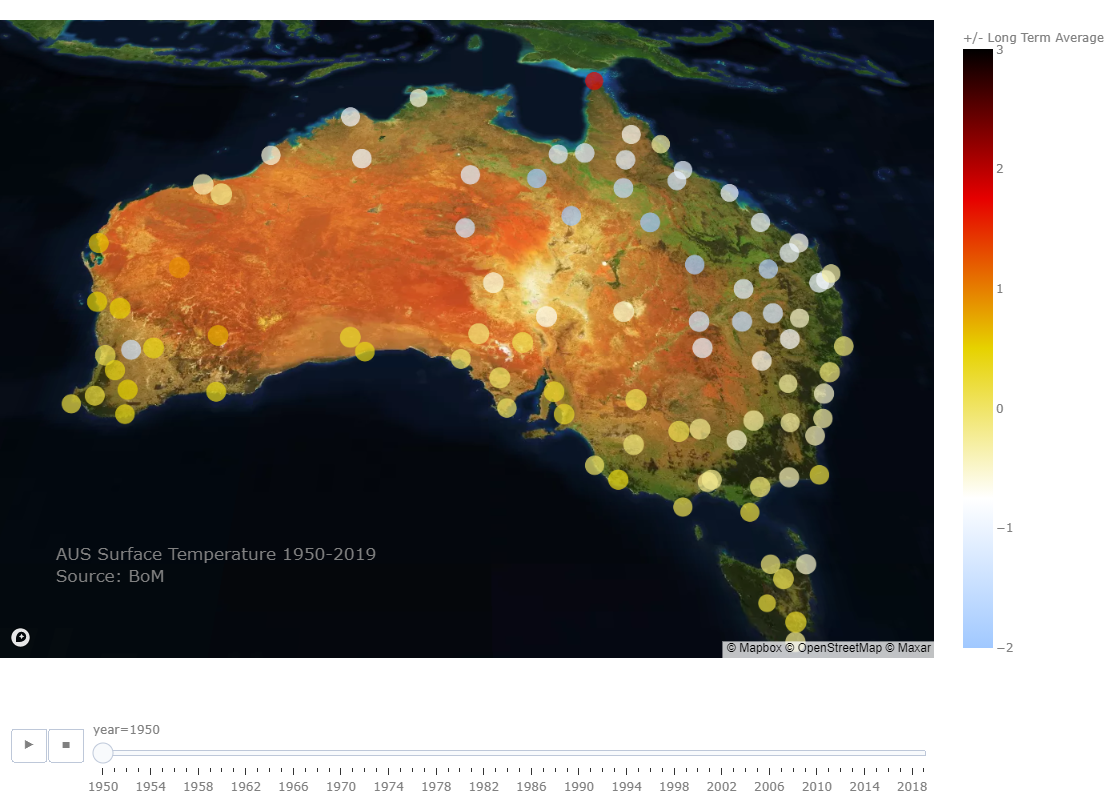

In [951]:
fig = px.scatter_mapbox(dfyear, lat="lat", 
                        lon="lon", 
                        size="max",
                        size_max = 20,
                        hover_name="site name", 
                        hover_data=["max","min"],
                        color="+/- Long Term Average",
                        color_continuous_scale="blackbody_r", 
                        range_color =[-2,3],
                        zoom=3.8, height=800, width=1000, 
                        animation_frame="year", 
                        )
fig.update_layout(
    mapbox_style="satellite",
    mapbox_accesstoken=token,
        title={
        'text': 'AUS Surface Temperature 1950-2019<br>Source: <a href="http://www.bom.gov.au/climate/data-services/station-data.shtml">BoM</a>',
        'y':0.3,
        'x':0.05,
        'xanchor': 'left',
        'yanchor': 'top'},
        font=dict(
            color="grey",
        )
)

#Adjust pitch and bearing to adjust the rotation
fig.update_layout(margin={"r":0,"t":20,"l":0,"b":20},
                  mapbox=dict(
                      pitch=40,
                      bearing=0,
                      center=dict(
                      lat=-31,
                      lon = 134),
                  ),


                 )
fig.show()